In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
# ResNet50 Transfer Learning
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
# Load CIFAR-10 dataset
(train_images,train_labels),(test_images,test_labels) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


10 classes, with 6,000 images per class.

The classes are:

Airplane

Automobile

Bird

Cat

Deer

Dog

Frog

Horse

Ship

Truck



In [ ]:
# Display class names for reference
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
print(f"\nCIFAR-10 Classes: {class_names}")


CIFAR-10 Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# Use subset of training data as specified
n = 10000

train_images = train_images[:n]
train_labels = train_labels[:n]

In [ ]:
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")


Training images shape: (10000, 32, 32, 3)
Training labels shape: (10000, 1)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


In [ ]:
# Data preprocessing
print("\nPreprocessing data...")
# Normalize pixel values to [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0


Preprocessing data...


In [ ]:
# Convert labels to categorical (one-hot encoding)
num_classes = 10
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [ ]:
print(f"After preprocessing:")
print(f"Training images range: {train_images.min()} to {train_images.max()}")
print(f"Training labels shape: {train_labels.shape}")


After preprocessing:
Training images range: 0.0 to 1.0
Training labels shape: (10000, 10)


In [ ]:
# Initialize ResNet50 base model
print("\nInitializing ResNet50 base model...")
base_model = ResNet50(
    weights='imagenet',
    include_top=False,  # Don't include the top classification layer
    input_shape=(32, 32, 3)
)


Initializing ResNet50 base model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze the base model layers
print("Freezing base model layers...")
base_model.trainable = False
print(f"Base model has {len(base_model.layers)} layers, all frozen")

Freezing base model layers...
Base model has 175 layers, all frozen


In [ ]:
# Build the "head" of the model
print("\nBuilding custom top layers...")
# Add global average pooling to reduce spatial dimensions
x = GlobalAveragePooling2D()(base_model.output)


Building custom top layers...


In [ ]:
# First hidden layer - 128 neurons
x = Dense(128, activation='relu', name='dense_1')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization

In [ ]:
# Second hidden layer - 64 neurons
x = Dense(64, activation='relu', name='dense_2')(x)
x = Dropout(0.3)(x)

In [ ]:
# Output layer for 10 classes
predictions = Dense(num_classes, activation='softmax', name='predictions')(x)

In [ ]:
# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Display model summary
print("\nModel Architecture:")
model.summary()



Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_3_c

 Total params: 23,858,890 (91.01 MB)

 Trainable params: 271,178 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Compile the model
print("\nCompiling model...")
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Compiling model...


In [ ]:
# Train the "head" (frozen base model)
print("\n" + "="*50)
print("PHASE 1: Training custom head (base model frozen)")
print("="*50)

history_phase1 = model.fit(
    train_images, train_labels,
    batch_size=32,
    epochs=10,
    validation_data=(test_images, test_labels),
    verbose=1
)


PHASE 1: Training custom head (base model frozen)
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 95s 277ms/step - accuracy: 0.1084 - loss: 2.4350 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 137s 262ms/step - accuracy: 0.1050 - loss: 2.3022 - val_accuracy: 0.0999 - val_loss: 2.3028
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 265ms/step - accuracy: 0.1009 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 265ms/step - accuracy: 0.1092 - loss: 2.3024 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 265ms/step - accuracy: 0.1021 - loss: 2.3017 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 138s 252ms/step - accuracy: 0.0995 - loss: 2.3026 - val_accuracy: 0.0997 - val_loss: 2.3029
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 85s 262ms/step - accuracy: 0.0953 - loss: 2.3021 - val_accuracy: 0.1000 - val_loss: 2.3030
Epoch 8/10
313/313 ━━━━━━━━

In [ ]:
# Unfreeze the base model and train end-to-end
print("\n" + "="*50)
print("PHASE 2: Fine-tuning entire model (unfreezing base model)")
print("="*50)

# Unfreeze the base model
base_model.trainable = True
print(f"Unfrozen base model - now training {len(base_model.layers)} additional layers")



PHASE 2: Fine-tuning entire model (unfreezing base model)
Unfrozen base model - now training 175 additional layers


In [ ]:
# Train the entire model
history_phase2 = model.fit(
    train_images, train_labels,
    batch_size=32,
    epochs=10,
    validation_data=(test_images, test_labels),
    verbose=1
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 262ms/step - accuracy: 0.0979 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3030
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 262ms/step - accuracy: 0.1071 - loss: 2.3022 - val_accuracy: 0.1000 - val_loss: 2.3030
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 256ms/step - accuracy: 0.0993 - loss: 2.3021 - val_accuracy: 0.1000 - val_loss: 2.3030
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 262ms/step - accuracy: 0.1065 - loss: 2.3025 - val_accuracy: 0.0998 - val_loss: 2.3030
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 254ms/step - accuracy: 0.0993 - loss: 2.3021 - val_accuracy: 0.1000 - val_loss: 2.3030
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 261ms/step - accuracy: 0.1019 - loss: 2.3023 - val_accuracy: 0.1000 - val_loss: 2.3030
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 261ms/step - accuracy: 0.1043 - loss: 2.3019 - val_accuracy: 0.1000 - val_loss: 2.3030
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 261ms/step - accuracy: 0.1032 - loss: 

In [ ]:
# Evaluate the model
print("\n" + "="*50)
print("FINAL EVALUATION")
print("="*50)

test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")



FINAL EVALUATION
Final Test Accuracy: 0.1000
Final Test Loss: 2.3030


In [ ]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

In [ ]:
# Combine histories from both phases
all_acc = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
all_val_acc = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
all_loss = history_phase1.history['loss'] + history_phase2.history['loss']
all_val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

epochs_range = range(1, len(all_acc) + 1)


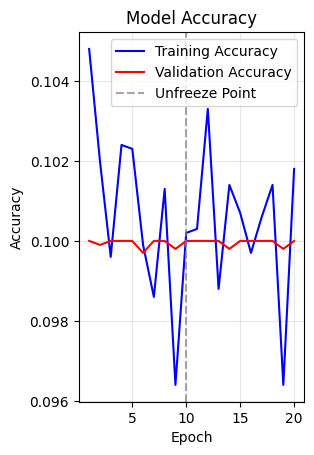

In [ ]:
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, all_acc, 'b-', label='Training Accuracy')
plt.plot(epochs_range, all_val_acc, 'r-', label='Validation Accuracy')
plt.axvline(x=10, color='gray', linestyle='--', alpha=0.7, label='Unfreeze Point')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

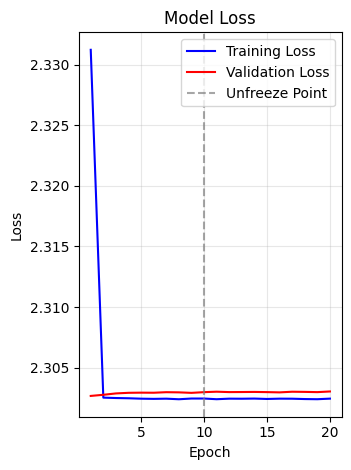

In [ ]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, all_loss, 'b-', label='Training Loss')
plt.plot(epochs_range, all_val_loss, 'r-', label='Validation Loss')
plt.axvline(x=10, color='gray', linestyle='--', alpha=0.7, label='Unfreeze Point')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()